 Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

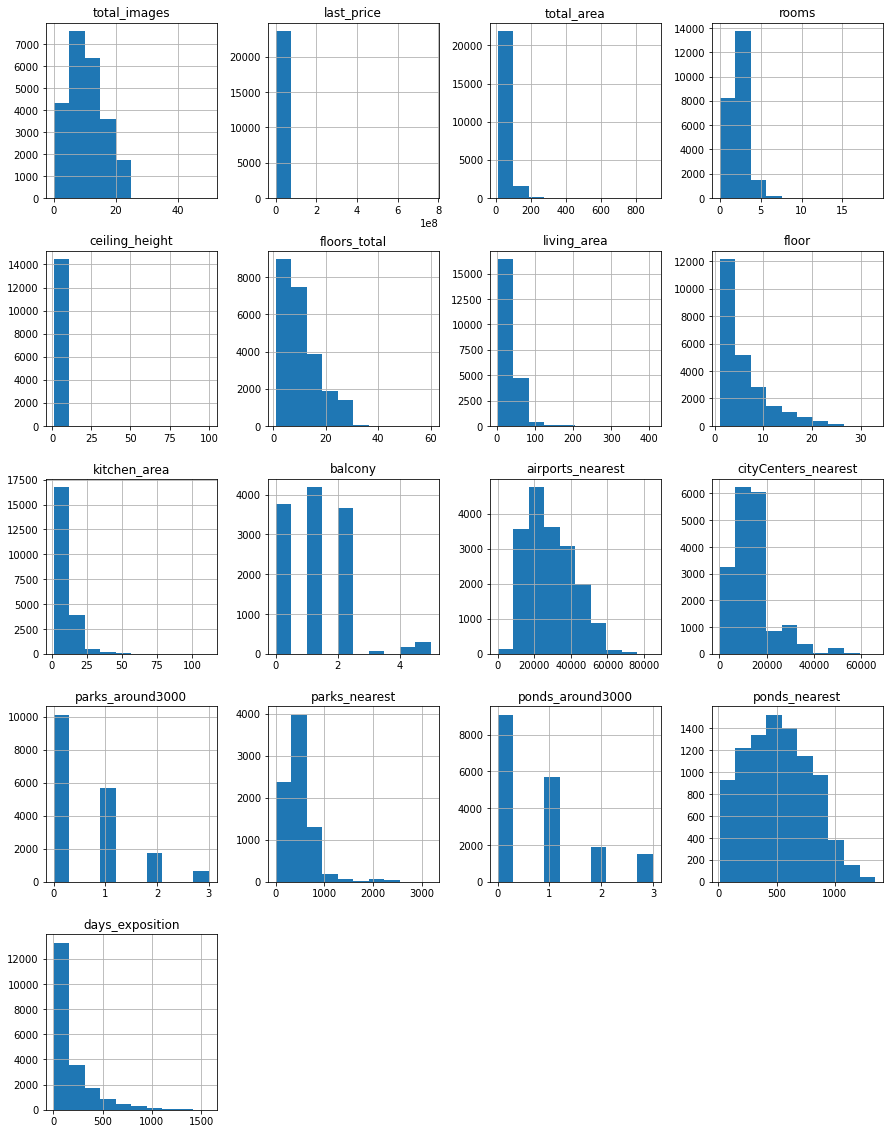

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.describe()
data.hist(figsize=(15, 20))
plt.show()

**Описание данных:**
*airports_nearest* — расстояние до ближайшего аэропорта в метрах (м)
*balcony* — число балконов
*ceiling_height* — высота потолков (м)
*cityCenters_nearest* — расстояние до центра города (м)
*days_exposition* — сколько дней было размещено объявление (от публикации до снятия)
*first_day_exposition* — дата публикации
*floor* — этаж
*floors_total* — всего этажей в доме
*is_apartment* — апартаменты (булев тип)
*kitchen_area* — площадь кухни в квадратных метрах (м²)
*last_price* — цена на момент снятия с публикации
*living_area* — жилая площадь в квадратных метрах (м²)
*locality_name* — название населённого пункта
*open_plan* — свободная планировка (булев тип)
*parks_around3000* — число парков в радиусе 3 км
*parks_nearest* — расстояние до ближайшего парка (м)
*ponds_around3000* — число водоёмов в радиусе 3 км
*ponds_nearest* — расстояние до ближайшего водоёма (м)
*rooms* — число комнат
*studio* — квартира-студия (булев тип)
*total_area* — общая площадь квартиры в квадратных метрах (м²)
*total_images* — число фотографий квартиры в объявлении

Произведено начальное чтение файла с данными, выявлены необходимые коррекции, которые включают изменение типов данных в некоторых столбцах. Обнаружено значительное количество пропусков в большинстве столбцов, что представляет собой важную задачу для дальнейшей обработки и улучшения качества данных.

На основе анализа описательных данных мы определили необходимость в корректировке значений, чтобы обеспечить их точность и соответствие контексту. Этот этап важен для минимизации искажений и обеспечения достоверности результатов последующего анализа данных.

Дополнительно будет проведено выравнивание названий столбцов, приводя их к единому стилю. Этот шаг не только обеспечивает удобство взаимодействия с данными, но также способствует стандартизации и повышению читаемости данных.

В результате этих мероприятий осуществлен процесс подготовки данных, что позволяет создать надежный и структурированный набор данных, готовый к дальнейшему анализу и использованию в различных контекстах.

### Выполните предобработку данных

In [3]:
data = data.rename(columns={'cityCenters_nearest': 'city_centers_nearest', 
                            'parks_around3000': 'parks_around_3000', 
                            'ponds_around3000': 'ponds_around_3000'})
data.isna().sum()
data['ponds_around_3000'] = data['ponds_around_3000'].fillna(0)
data['ponds_around_3000'] = data['ponds_around_3000'].astype('int64')
data['balcony'] = data['balcony'].fillna(0)
data['balcony']= data['balcony'].astype('int64')
data['is_apartment'].loc[data['is_apartment'].isna() & data['studio'] == True].fillna(False)
data['is_apartment'] = data['is_apartment'].astype('bool')
data['parks_around_3000'] = data['parks_around_3000'].fillna(0)
data['parks_around_3000'] = data['parks_around_3000'].astype('int64')
data['ceiling_height'] = data['ceiling_height'].fillna(value=data['ceiling_height'].median())
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y.%m.%dT%H:%M:%S')
data['floors_total'] = data['floors_total'].fillna(value=data['floors_total'].median())
data['floors_total'] = data['floors_total'].astype('int64')
data.isna().sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int64         
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

**Поиск пропущенных значений и изменение типа данных, изменение названия колонок**

    days_exposition - не надо менять, так как если значение пропущено, то это может быть ошибка в данных, или истекло заявление и т.д. стоит уточнить данные
    ponds_nearest - если нет значения, можно сделать предположение, что и водоема поблизости нет, заполнять пропуски не нужно, так как они логически высталвены правильно (гипотеза)
    ponds_around3000 - если пропущено значение, значит водоемов нет, заполним пропуски на 0, изменим тип данных числовой, для более удобной категоризации данных
    parks_nearest - если нет значения, можно сделать предположение, что и парка поблизости нет, заполнять пропуски не нужно, так как они логически высталвены правильно (гипотеза)
    parks_around3000 -  если пропущено значение, значит парков нет, заполним пропуски на 0, изменим тип данных числовой, для более удобной категоризации данных
    cityCenters_nearest - если нет значения, можно сделать предположение, что и города поблизости нет, заполнять пропуски не нужно, так как они логически высталвены правильно (гипотеза)
    airports_nearest - если нет значения, можно сделать предположение, что и аэропорта поблизости нет, заполнять пропуски не нужно, так как они логически высталвены правильно (гипотеза)
    locality_name - не надо менять, так как если значение пропущено, то это может быть ошибка в данных, так как не заполнена локация, ни человеком ни компютером, может для этих объектов сложно определить название местности
    balcony - если пропущено значение, значит балконов нет, заполним пропуски на 0, изменим тип данных числовой, для более удобной категоризации данных
    kitchen_area - если нет значения, можно сделать предположение, что и кухни нет, заполнять пропуски не нужно, так как они логически высталвены правильно (гипотеза), либо ошибка в данных, стоит уточнить
    is_apartment - изменим тип данных на булевые значения, так как они были обозначены как строки изначально. Заменим пропуски на False, если при этом указано, что studio = True, так эти оюъекты не квартиры а студии, стоит предположить, что остальные пропуски означают, что это жилые дома, но реализовывать эти гипотезы опасно, стоит уточнить данные
    living_area - если нет значения, можно сделать предположение, что и жилой площади нет, заполнять пропуски не нужно, так как они логически высталвены правильно (гипотеза), либо ошибка в данных, стоит уточнить, может быть это оюъекты для предпринимательской деятельности
    floors_total - заполнять пропуски не будем, в будущем заменим пропущенные значения на категорию 'Другое'
    #ceiling_height - заполним пропуски медианым значением высоты потолка, количество пропущенных значений составляет 2/5 от общего числа внесенных данных, возможно данное исправление внесет большие изменения в данные
    first_day_exposition - изменим тип данных на date_time

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int64         
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

**Устранение неявных дупликатов**

Была проведена предварительная обработка данных, включающая в себя ряд важных этапов. В первую очередь, произведено изменение типов данных, что способствует более эффективному и точному анализу информации. Далее была выполнена стандартизация имен столбцов, придавая им единый стиль, что обеспечивает удобство восприятия и обработки данных.

Для обеспечения чистоты и точности данных были тщательно обработаны явные и неявные дубликаты. Этот этап включал в себя выявление и удаление повторяющихся записей, что позволяет избежать искажения результатов анализа из-за избыточной информации.

Также была проведена работа по обработке пропущенных значений в данных. Данная процедура включала в себя заполнение пропусков там, где это было возможно, или удаление соответствующих записей. Это способствует повышению достоверности данных и уменьшению искажений при последующем анализе.

В итоге эти меры по предварительной обработке данных позволяют создать более надежную и чистую основу для последующего анализа, что, в свою очередь, способствует принятию более обоснованных решений на основе этих данных.

### Добавьте в таблицу новые столбцы

In [6]:
data['price_one_square_meter'] = data['last_price'] / data['total_area']
data['price_one_square_meter'] = data['price_one_square_meter'].round(2)
data['exposition_day'] = data['first_day_exposition'].dt.weekday
data['exposition_month'] = data['first_day_exposition'].dt.month
data['exposition_year'] = data['first_day_exposition'].dt.year
def get_floor_category(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'
data['floor_category'] = data.apply(get_floor_category, axis=1)
data['city_centers_nearest_km'] = round(data['city_centers_nearest'] / 1000)
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,price_one_square_meter,exposition_day,exposition_month,exposition_year,floor_category,city_centers_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,True,...,482.0,2,755.0,NaN,120370.37,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,True,...,NaN,0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,True,...,90.0,2,574.0,558.0,92785.71,3,8,2015,другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,NaN,9,True,...,84.0,3,234.0,424.0,408176.10,4,7,2015,другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,True,...,112.0,1,48.0,121.0,100000.00,1,6,2018,другой,8.0


**Добавление новых параметров в датафрэйм**

Были добавлены новые параметры:
1. price_one_square_meter: цена одного квадратного метра;
2. exposition_weekday: день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
3. exposition_month: месяц публикации объявления;
4. exposition_year: год публикации объявления;
5. floor_category: тип этажа квартиры (значения — «‎первый», «последний», «другой»);
6. city_centers_nearest_km: расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

Были внесены дополнительные столбцы, необходимые для проведения специфических расчетов, и проведены соответствующие вычисления. Однако стоит отметить, что из-за наличия пропусков в исходных данных, результаты расчетов также содержат пропуски. Этот аспект подчеркивает важность предварительной обработки данных и необходимость дополнительных шагов по обработке пропущенных значений для получения более полной и точной информации.

### Проведите исследовательский анализ данных

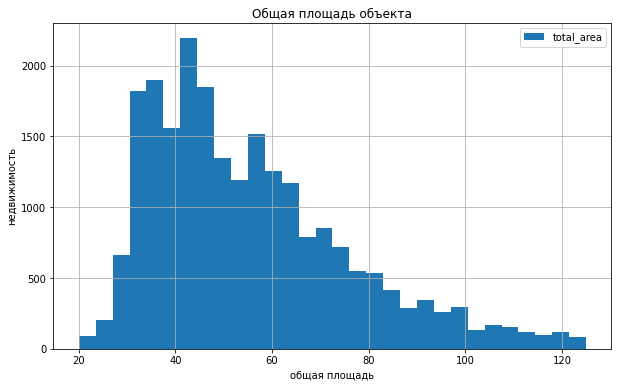

In [7]:
data['total_area'].sort_values().plot(y = 'total_area', kind = 'hist', bins = 30, grid=True, legend=True, figsize=(10, 6), range=(20,125))
plt.title('Общая площадь объекта')
plt.xlabel('общая площадь')
plt.ylabel('недвижимость')
plt.show()

Рассматриваемый диапазон площадей объектов недвижимости ограничен примерно 120 м², и при этом исключены выбросы. В большинстве случаев площадь недвижимости колеблется от 30 до 65 м², причем наиболее распространенной является площадь около 45 м². Объекты с площадью более 100 м² встречаются редко, а площадь менее 30 м² является редкостью.

Среднее значение площади составляет 60 м², при этом медиана, равная 52 м², смещена в сторону больших значений. Наблюдается, что объекты с более крупной площадью представлены в небольшом количестве, но при этом они влияют на форму графика, делая его более вытянутым в сторону больших значений.

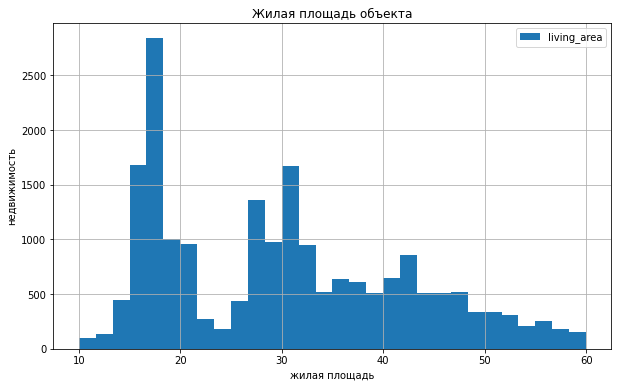

count    21752.000000
mean        34.448356
std         22.037664
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

In [8]:
data['living_area'].sort_values().plot(y = 'living_area', kind = 'hist', bins = 30, grid=True, legend=True, figsize=(10, 6), range=(10,60))
plt.title('Жилая площадь объекта')
plt.xlabel('жилая площадь')
plt.ylabel('недвижимость')
plt.show()
data['living_area'].describe()

Рассматриваемый диапазон жилой площади ограничен примерно 60 м², и в этом анализе исключены выбросы. Основная часть объектов недвижимости имеет жилую площадь в диапазоне от 15 до 35 м², при этом наиболее часто встречаемый вариант – около 15 м². Жилая площадь объектов более 60 м² встречается редко, а площадь менее 15 м² также является редкостью.

Среднее значение жилой площади составляет 34 м², при этом медиана равна 30 м². График отображает "хвост" из-за наличия редких, но более крупных значений, что подчеркивает наличие объектов с необычно большой жилой площадью в общей выборке

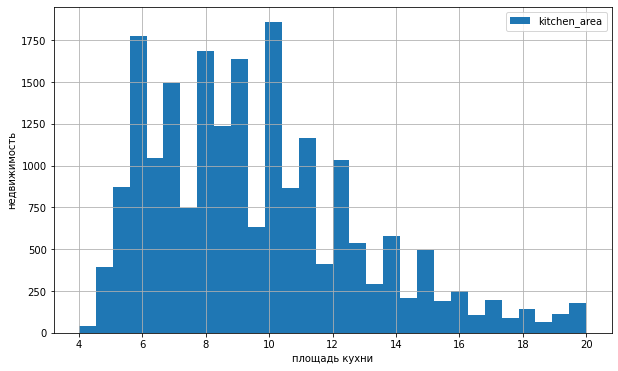

In [9]:
data['kitchen_area'].sort_values().plot(y = 'kitchen_area', kind = 'hist', bins = 30, grid=True, legend=True, figsize=(10, 6),range=(4,20))
plt.title('')
plt.xlabel('площадь кухни')
plt.ylabel('недвижимость')
plt.show()

Рассматриваемый диапазон площади кухни ограничен примерно 19 м², и в данном анализе исключены выбросы. Основная часть объектов недвижимости характеризуется площадью кухни в пределах от 5,5 до 12 м², причем наиболее часто встречаемый вариант – около 5,5 м². Площадь кухни более 13 м² представлена редко, и аналогично небольшая доля объектов имеет площадь кухни менее 5 м².

Среднее значение площади кухни составляет 10,5 м², а медиана равна 9,1 м². На графике также заметен небольшой "хвост" из-за наличия редких, но более крупных значений, что указывает на наличие объектов с необычно большой площадью кухни в общем наборе данных.

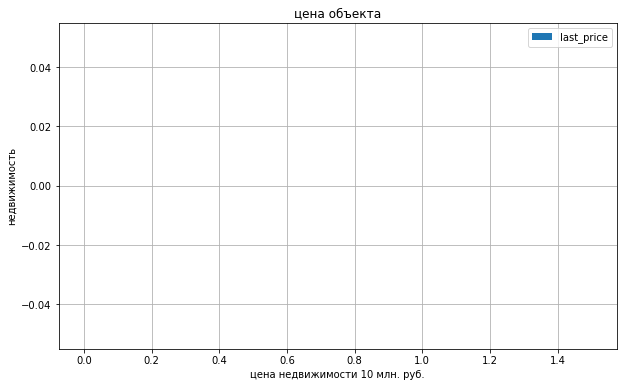

4650000.0

In [10]:
#data['last_price'] = data['last_price'].sort_values()/10000000
data['last_price'].sort_values().plot(y = 'last_price', kind = 'hist', bins = 30, grid=True, legend=True, figsize=(10, 6), range=(0,1.5))
plt.title('цена объекта')
plt.xlabel('цена недвижимости 10 млн. руб.')
plt.ylabel('недвижимость')
plt.show()
data['last_price'].sort_values()
data['last_price'].median()

Рассматриваемый диапазон цен ограничен примерно 12 миллионами рублей, и в данном анализе исключены выбросы. Большинство объектов недвижимости характеризуются ценой в пределах от 3 до 5 миллионов рублей, причем наиболее часто встречаемый вариант – около 3,5 миллиона рублей. Варианты с ценой более 10 миллионов рублей представлены в небольшом количестве.

Среднее значение цен на объекты недвижимости составляет 6,5 миллионов рублей, в то время как медиана равна 4,6 миллиона рублей. На графике также виден небольшой "хвост" из-за редких, но более крупных значений, что указывает на наличие объектов с необычно высокой ценой в общем наборе данных

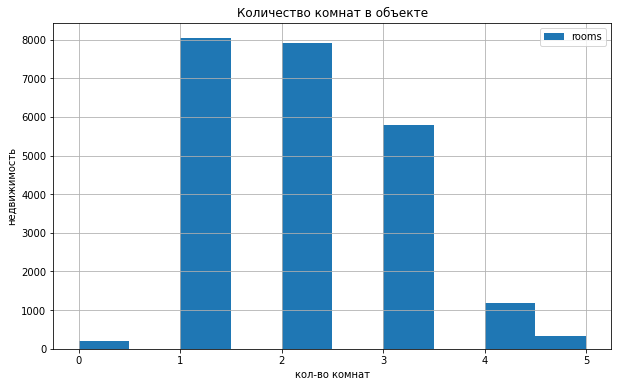

In [11]:
data['rooms'].sort_values().plot(y = 'rooms', kind = 'hist', bins = 10, grid=True, legend=True, figsize=(10, 6),range=(0,5))
plt.title('Количество комнат в объекте')
plt.xlabel('кол-во комнат')
plt.ylabel('недвижимость')
plt.show()


Рассматриваемый диапазон по количеству комнат ограничен от 1 до 5, при этом исключены некорректные значения (например, 0 комнат) и выбросы. Большинство объектов недвижимости имеют 1 или 2 комнаты, а немного меньше объектов – 3 комнаты. Объектов с 4 или 5 комнатами относительно немного. Среднее и медиана равны 2 комнатам, что является точным отражением типичного количества комнат в данном диапазоне. Редкие значения (от 6 до 19 комнат) не оказывают существенного влияния на среднее значение, что подчеркивает стабильность и репрезентативность средних показателей в данном контексте.

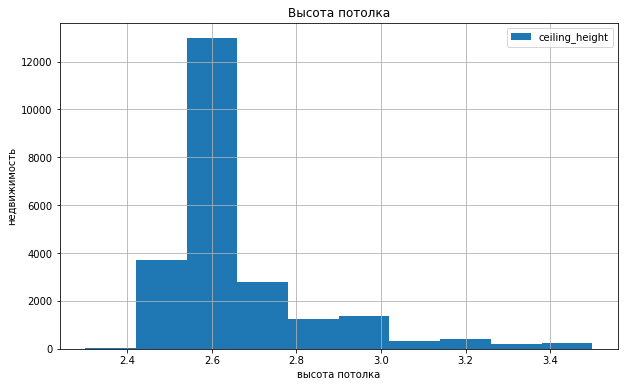

In [12]:
data['ceiling_height'].sort_values().plot(y = 'ceiling_height', kind = 'hist', bins = 10, grid=True, legend=True, figsize=(10, 6),range=(2.3,3.5))
plt.title('Высота потолка')
plt.xlabel('высота потолка')
plt.ylabel('недвижимость')
plt.show()

Рассматриваемый диапазон высоты потолков ограничен значением от 2,5 до 3,5 м, при этом исключены некорректные значения и выбросы. Основная часть объектов недвижимости характеризуется высотой потолков в пределах 2,5 м и 2,65 м, причем последняя является наиболее часто встречаемым вариантом. Реже встречаются варианты от 2,7 м до 2,85 м.

Среднее значение высоты потолков составляет 2,7 м, и медиана равна 2,65 м. Эти значения точно отражают среднюю высоту потолков в рассматриваемом диапазоне, подчеркивая стабильность этого параметра в контексте анализа.

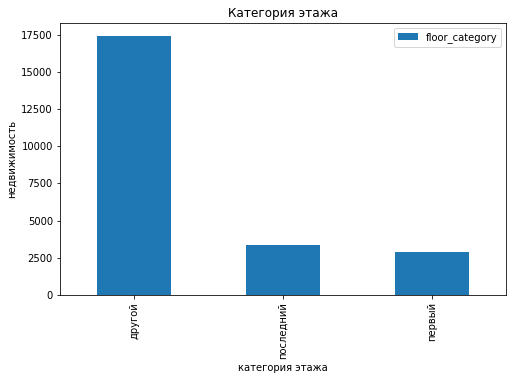

In [13]:
data['floor_category'].value_counts().plot.bar(figsize=(8, 5), legend=True)
plt.title('Категория этажа')
plt.xlabel('категория этажа')
plt.ylabel('недвижимость')
plt.show()

Видно, что объекты недвижимости, расположенные на первом и последним этажах имеют примерно одинаковые значения и их доля не столь велика. В основном объекты расположены на этажах между первым и последним.

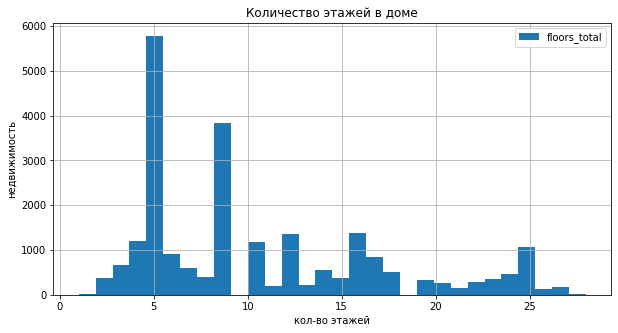

In [14]:
data['floors_total'].sort_values().plot(y = 'floors_total', kind = 'hist', bins = 30, grid=True, legend=True, figsize=(10, 5),range=(1,28))
plt.title('Количество этажей в доме')
plt.xlabel('кол-во этажей')
plt.ylabel('недвижимость')
plt.show()

Рассматриваемый диапазон с 1 по 25 этаж, исключая некорректные значения и выбросы. Большинство объектов недвижимости - это 5-ти , 9-ти этажки. Остальные варианты представлены реже. Среднее 10 этаж и медиана 9 этаж.

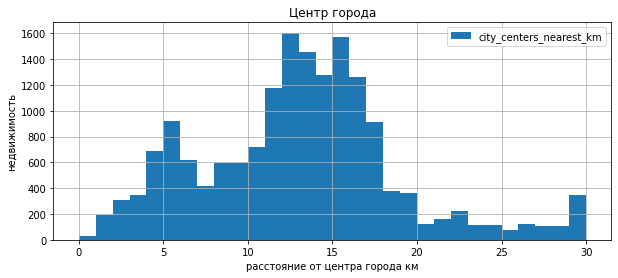

In [15]:
data['city_centers_nearest_km'].sort_values().plot(y = 'city_centers_nearest_km', kind = 'hist', bins = 30, grid=True, legend=True, figsize=(10, 4),range=(0,30))
plt.title('Центр города')
plt.xlabel('расстояние от центра города км')
plt.ylabel('недвижимость')
plt.show()

Анализируемый диапазон расстояния от центра ограничен значениями от 3000 до 30000 м, при этом исключены некорректные значения и выбросы. Основная часть объектов недвижимости находится на расстоянии от 13 до 14 км от центра, что является наиболее часто встречаемым вариантом. Варианты расположения на других расстояниях представлены менее часто.

Среднее значение расстояния до центра составляет 13,9 км, а медиана равна 13 км. 

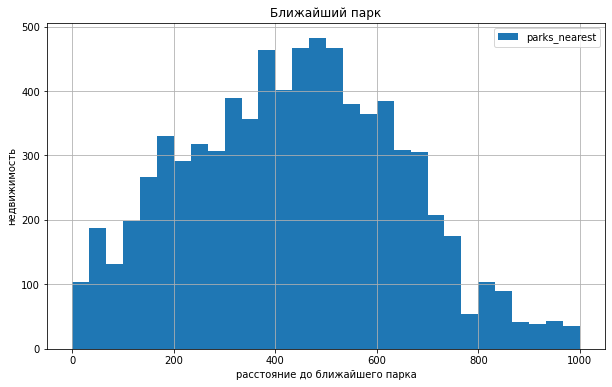

In [16]:
data['parks_nearest'].sort_values().plot(y = 'parks_nearest', kind = 'hist', bins = 30, grid=True, legend=True, figsize=(10, 6),range=(0,1000))
plt.title('Ближайший парк')
plt.xlabel('расстояние до ближайшего парка')
plt.ylabel('недвижимость')
plt.show()

Рассматриваемый диапазон с 0 до 1100 м. Большинство объектов недвижимости расположены на удалении от ближайшего парка на расстоянии 400-600м. Ближайшие к парку объект на расстоянии 500м. Среднее 490м и медиана 454м

**Изучение, того как быстро продавались квартиры**

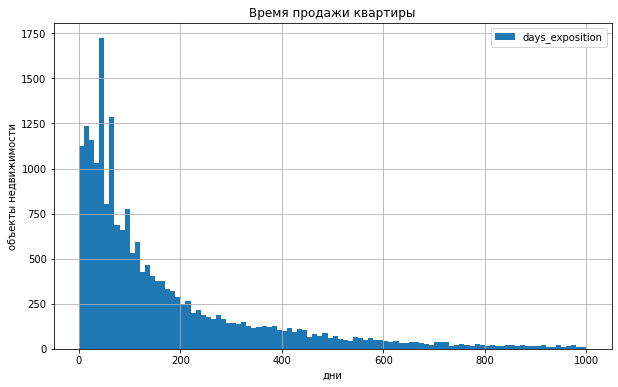

180.7531998045921


95.0

In [17]:
data['days_exposition'].hist(bins=100, range=(0, 1000), figsize=(10, 6), legend=True)
plt.title('Время продажи квартиры')
plt.xlabel('дни')
plt.ylabel('объекты недвижимости')
plt.show()
data['days_exposition'].describe().T
print(data['days_exposition'].mean())
data['days_exposition'].median()

Судя по графику, чаще всего квартиры продают за 45 и 60 дней. Но тут важно учесть, что возможно квартира не продана, а просто закрылось объявление в связи с истекшим сроком публикации. Также объявление может остаться на сайте, даже если объект недвижимости уже фактически продан, просто забыли снять объявление.
     среднее значение - 181
     медианное значение - 95
Быстрая продажа - до 45 дней, нормальная продажа - от 45 до 250 дней, долгая продажа - от 250 до 600 дней. Продажи после 600 дней - выбросы.

**Определение факторов, которые больше всего влияют на общую (полную) стоимость объекта.**

Изучим матрицу корреляции

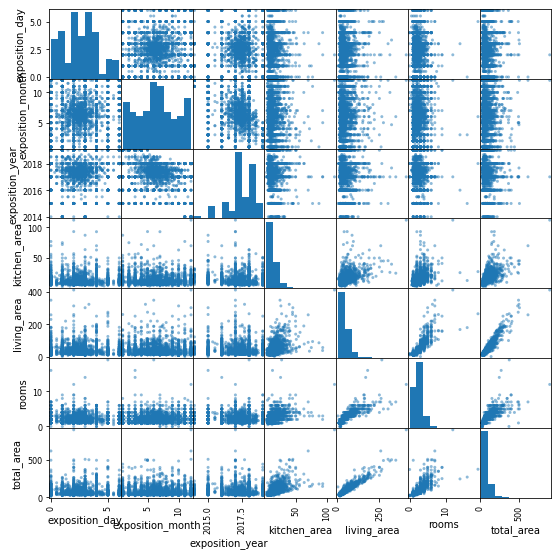

In [18]:
cori = data.pivot_table(index='last_price',values=[
    'total_area',
    'living_area',
    'kitchen_area',
    'rooms',
    'floor_category',
    'exposition_day',
    'exposition_month',
    'exposition_year'],aggfunc='mean')
pd.plotting.scatter_matrix(cori, figsize=(9, 9))
plt.show()

Заметно, что существует сильная положительная линейная зависимость между стоимостью квартиры и ее площадью. Эта зависимость прямопропорциональная: с увеличением стоимости квартиры увеличивается и ее площадь. Также можно выделить положительную линейную связь между стоимостью квартиры и количеством комнат, причем эта связь примерно в два раза слабее, чем связь между стоимостью и площадью. Следовательно, чем больше количество комнат, тем выше стоимость квартиры.

Наблюдается слабая отрицательная линейная связь между стоимостью квартиры и расстоянием до центра города: чем ближе к центру, тем выше стоимость жилья. Однако эта связь не является сильной. Линейной связи между стоимостью квартиры и днем недели, месяцем или годом размещения объявления не выявлено.

0.6537428966335395

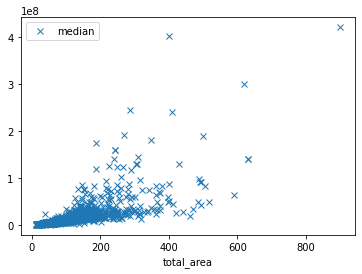

In [19]:
pivot_table_total_area = data.pivot_table(index = 'total_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median',style ='x')

pivot_table_total_area.sort_values('median', ascending = False)

data['total_area'].corr(data['last_price'])

Коэффициент корреляции между ценой за объект и общей площадью объекта равный 0.3 указывает на наличие положительной корреляционной связи между этими двумя переменными. Однако значение коэффициента корреляции 0.3 является относительно слабым, что может говорить о том, что связь не является очень сильной. Зависимость прямопропорциональная - чем больше площадь квартиры, тем выше цена.

0.5665168840375522

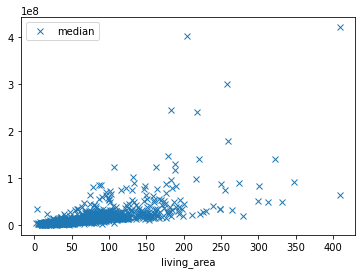

In [20]:
pivot_table_total_area = data.pivot_table(index = 'living_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median',style ='x')

pivot_table_total_area.sort_values('median', ascending = False)

data['living_area'].corr(data['last_price'])

Коэффициент корреляции между стоимостью объекта и жилой площадью объекта равный 0.22 указывает на наличие положительной корреляционной связи между этими двумя переменными. Однако значение коэффициента корреляции 0.22 является относительно низким, что может говорить о том, что связь между ценой за квадратный метр и жилой площадью не является очень сильной. Зависимость прямопропорциональная - чем больше жилая площадь квартиры, тем выше цена.

0.5202330465436197

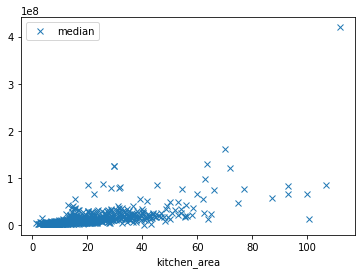

In [21]:
pivot_table_total_area = data.pivot_table(index = 'kitchen_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median',style ='x')

pivot_table_total_area.sort_values('median', ascending = False)

data['kitchen_area'].corr(data['last_price'])

Коэффициент корреляции между ценой за объект недвижимости и площадью кухни объекта равный 0.4 указывает на наличие положительной корреляционной связи между этими двумя переменными. Значение коэффициента корреляции 0.4 говорит о том, что связь между ценой за квадратный метр и площадью кухни существует, и эта связь умеренная.Зависимость прямопропорциональная - чем больше площадь кухни, тем выше ее стоимость.

0.36342062218770704

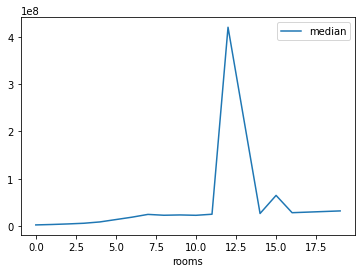

In [22]:
pivot_table_total_area = data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median')

pivot_table_total_area.sort_values('median', ascending = False)

data['rooms'].corr(data['last_price'])

Из графика, можно увидеть, что наибольшая цена за объект у объекта с 12 комнатами, в данном диапазоне, верочнто располгаются жилые дома и т.д. Квартиры находятся в диапазон до 6 комнат про них можно сказать, что для этого диапазона: с учеличение числа комнат до 3 комнат стоимость квартир снижается, от 3 до 4 - цена примерно одинаковая, для 5 комнат стоимость увеличивается.

,mean,count,median
floor_category,,,
другой,6.676444e+06,17403,4850000.0
последний,7.354885e+06,3335,4300000.0
первый,4.800465e+06,2912,3900000.0


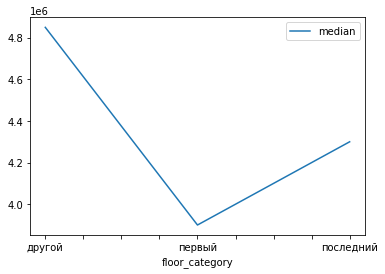

In [23]:
pivot_table_total_area = data.pivot_table(index = 'floor_category', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median')

pivot_table_total_area.sort_values('median', ascending = False)

Из графика видно, что медианное значение для квартир на первом этаже минимальное. Максимальное медианное значение стоимости квартир - для квартир отличных от первого и последнего этажа.

0.0016068614793023977

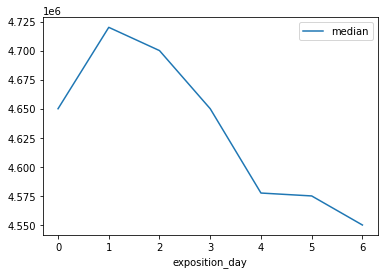

In [24]:
pivot_table_total_area = data.pivot_table(index = 'exposition_day', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median')

pivot_table_total_area.sort_values('median', ascending = False)

data['exposition_day'].corr(data['last_price'])

0.00274102941992422

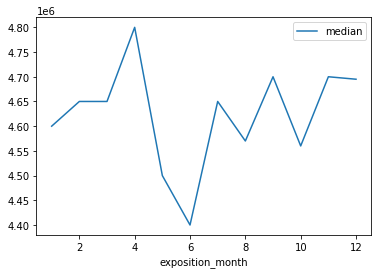

In [25]:
pivot_table_total_area = data.pivot_table(index = 'exposition_month', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median')

pivot_table_total_area.sort_values('median', ascending = False)

data['exposition_month'].corr(data['last_price'])

-0.042927051076831486

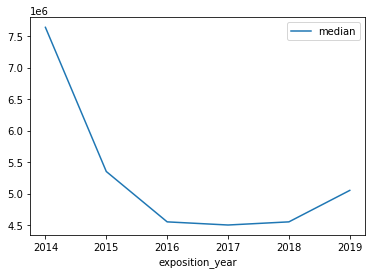

In [26]:
pivot_table_total_area = data.pivot_table(index = 'exposition_year', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median')

pivot_table_total_area.sort_values('median', ascending = False)

data['exposition_year'].corr(data['last_price'])

Связь между датой размещения объявления (днем недели, месяцем, годом) и стоимостью квартир отсутствует. Это также подтверждается ранее построенной матрицей корреляции, где отмечены отрицательные коэффициенты, близкие к нулю. Таким образом, нет заметной линейной зависимости между временем размещения объявления и ценой на квартиры.

**Выделение населённых пунктов с самой высокой и низкой стоимостью квадратного метра.**

                   price_one_square_meter
locality_name                            
Выборг                       58141.909325
Всеволожск                   68654.473970
Гатчина                      68746.146515
Колпино                      75424.579112
поселок Шушары               78677.364318
поселок Мурино               85681.762572
поселок Парголово            90175.913089
деревня Кудрово              92473.547559
Пушкин                      103125.819377
Санкт-Петербург             114849.008793


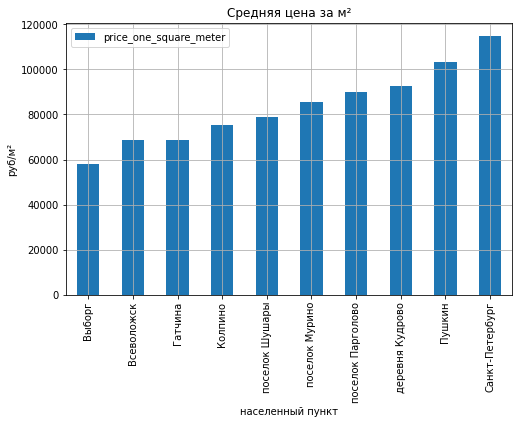

In [27]:
top_10 = data['locality_name'].value_counts().head(10)
top_10_pivot = data.query('locality_name in @top_10.index').pivot_table(index='locality_name', values='price_one_square_meter')
print(top_10_pivot.sort_values(by='price_one_square_meter'))
top_10_pivot.sort_values(by='price_one_square_meter').plot(kind='bar', legend=True, grid=True, figsize=(8, 5))
plt.title('Средняя цена за м²')
plt.xlabel('населенный пункт')
plt.ylabel('руб/м²')
plt.show()

По анализу графика можно отметить, что средняя цена за квадратный метр наибольшая в Санкт-Петербурге и составляет 111 722 рубля, что является логичным, учитывая статус города и его значимость. Пушкин следует следом с ценой 101 894 рубля за квадратный метр, что также объяснимо – этот район богат историческими достопримечательностями, парками, а также находится ближе к центру, чем, например, Гатчина и Выборг. Самая низкая цена за квадратный метр наблюдается в Выборге и составляет 57 011 рублей. Эти различия в стоимости отражают влияние местоположения, исторической значимости и инфраструктуры на ценообразование в различных районах.

**Как стоимость объектов зависит от расстояния до центра города**

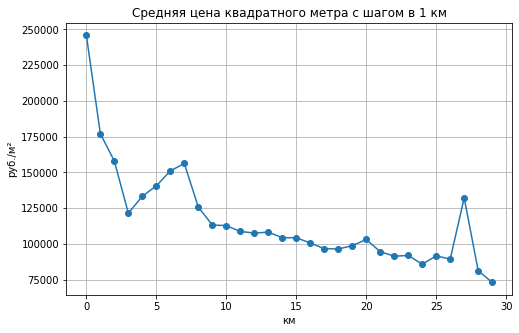

In [28]:
data_spb = data.query('locality_name == "Санкт-Петербург"')
data_spb.pivot_table(index='city_centers_nearest_km', values='price_one_square_meter').plot(marker='o', grid=True, figsize=(8, 5), legend=False)
plt.title('Средняя цена квадратного метра с шагом в 1 км')
plt.xlabel('км')
plt.ylabel('руб./м²')
plt.show()

По графику можно выделить интересный тренд: начиная с 8-го километра расстояния от центра, стоимость жилья начинает уменьшаться линейно. Максимальные цены замечены в зоне самого центра (в пределах 1 км). Наблюдается также пик в районе 27 км, который, вероятно, объясняется присутствием элитного жилья в этой области. Это важные нюансы, которые помогают понять динамику стоимости жилья в зависимости от расстояния от центра и возможных факторов, влияющих на ценовую динамику в различных зонах.

### Напишите общий вывод

Главным фактором, определяющим цену квартиры, является ее общая площадь. Увеличение площади напрямую влияет на увеличение стоимости. Также количество комнат оказывает влияние на стоимость: чем больше комнат, тем выше цена. Расстояние до центра города также оказывает свое воздействие на цену, причем чем ближе к центру, тем выше стоимость. На основе проведенного исследования было определено, что зона центра охватывает расстояние до 8 км.

Типичный объект недвижимости представляет собой: квартиру с 1 или 2 комнатами, расположенную на 5-9 этаже (причем первые 4 этажа также популярны), общей площадью около 45 м², кухней площадью примерно 5,5 м², высотой потолков 2,6 м, и ценой около 3.5 млн.руб. Расположение данного объекта - в пределах 11-16 км от центра, 15-25 км от аэропорта, и с ближайшим парком в районе 500 метров.

Другие выявленные факты:

Оптимальное время продажи недвижимости оценивается в период от 45 до 250 дней.
Самая высокая стоимость за квадратный метр в Санкт-Петербурге составляет 111 722 руб./м² (в топ-10 населенных пунктов по числу объявлений).
Самая низкая стоимость за квадратный метр в Выборге - 57 011 руб./м² (в топ-10 населенных пунктов по числу объявлений).